# Pytorch Model 

this notebook will demonstrate the same techniques and practices used in Emotion_Classifier notebook but using Pytorch instead of Tensorflow. Pytorch comes with enough tools that we don't need Librosa as well and Pytorch's audio module "Torchaudio" has audio tranformers that are based on Librosa's fundementals. Then biggest difference might be that Pytorch will turn an audiofile into a Tensor instead of a Numpy array like with Librosa. 

In [1]:
# Importing Necessary Libraries 

# Standard Python Operations 
import pandas as pd 
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Audio and torch data
from scipy import signal 
import librosa 
import torchaudio 
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio



# Neural Network 
import torch 
import torch.nn as nn 

torch.manual_seed(0)



# Preparing data 
First the data will be prepared the same way as in my other notebooks. A Pandas Dataframe will be created that contains the Path of the audio file and its respected class label for each observation. Then I will create a custom Data Class object using Pytorch's Data Class

In [15]:
class RavdessDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        #self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        #signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        #signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 3]


if __name__ == "__main__":
    ANNOTATIONS_FILE = "/Users/stephen/Emotion_Detection-/data/metadata.csv"
    AUDIO_DIR = "/Users/stephen/Emotion_Detection-/data/RAVDESS"
    SAMPLE_RATE = 22050
    NUM_SAMPLES = 22050

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    

    rav = RavdessDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            None,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
    print(f"There are {len(rav)} samples in the dataset.")
    signal, label = rav[0]

Using device cpu
There are 1380 samples in the dataset.


# Pytorch Functions 
Taken directly from the Pytorch documentation and tutorials, we'll define some functions to easily visualize the data. 
https://pytorch.org/tutorials/beginner/audio_feature_extractions_tutorial.html

In [16]:
# helper functions 

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Visualize data

In [19]:
test_sample, test_label = rav[680]
print(test_label)

sad


In [20]:
print_stats(test_sample)

Shape: (1, 22050)
Dtype: torch.float32
 - Max:      0.000
 - Min:     -0.000
 - Mean:    -0.000
 - Std Dev:  0.000

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.6221e-07,
          2.6366e-05, -2.3299e-07]])



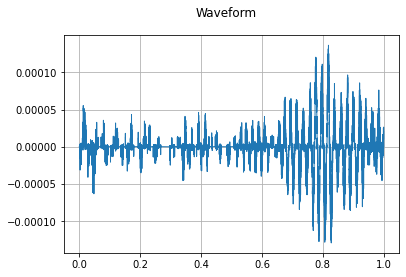

In [22]:
plot_waveform(test_sample, sample_rate=22050)

In [ ]:
n_fft = 1024
win_length = None 
hop_length = 512 

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(test_sample)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

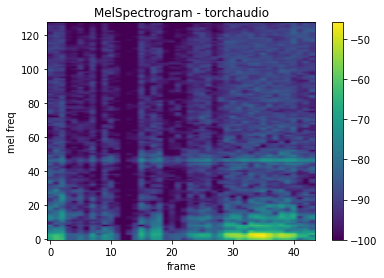

In [23]:


n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate=22050

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(test_sample)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

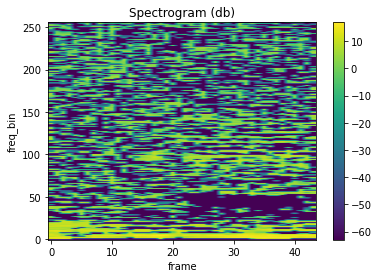

In [24]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(test_sample)

plot_spectrogram(mfcc[0])

In [29]:
play_audio(test_sample, 16000)